# 403 Iterate for CDR
In this notebook we will assess the new CDR needs based on an iterative search.

In [1]:
ENSEMBLE_MEMBER = 4
MODEL='REMIND-MAgPIE 2.1-4.3'
SCENARIO='DeepElec_SSP2_ HighRE_Budg900'

In [2]:
import json
import os
import platform
from pathlib import Path

import copy
import dotenv
import matplotlib.pyplot as plt
import openscm_runner
import scmdata
import pyam
import pandas as pd
import numpy as np
from scipy.optimize import minimize_scalar

import sys
sys.path.append('../scripts/')
from cdr import *

from climate_assessment.climate.wg3 import clean_wg3_scenarios
from climate_assessment.climate.magicc7 import get_magicc7_configurations
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/scmdata/database/_database.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdman


In [3]:
dotenv.load_dotenv()

True

In [4]:
os_type = platform.system()
print(os_type)

match os_type:
    case 'Darwin':
        os.environ['MAGICC_EXECUTABLE_7']=os.path.join(
            os.environ['MAGICC_7_BIN'],
            'magicc-darwin-amd64'
        )
        os.environ['DYLD_LIBRARY_PATH'] = os.environ['DYLD_PATH_GCC']
    case 'Linux':
        os.environ['MAGICC_EXECUTABLE_7']=os.path.join(
            os.environ['MAGICC_7_BIN'],
            'magicc'
        )

Linux


Step 1: Load the MAGICC configurations and select the ensemble member (climate realisation) that we want to run through for this study.

In [5]:
magicc_cfgs, _ = get_magicc7_configurations(
    magicc_version="v7.5.3",
    magicc_probabilistic_file=os.environ['MAGICC_AR6_PROBABILISTIC_DISTRIBUTION'],
    magicc_extra_config=None,
    num_cfgs=600,
    co2_and_non_co2_warming=False
)

In [6]:
config_for_run = [magicc_cfgs[ENSEMBLE_MEMBER]]

Step 2: Load the necessary emissions-related files for this assessment. We need:
* The adapted novel CDR estimates lookup table
* The emission dataset to input to the climate model
* The original novel CDR estimates that we will use for the calibration iterations and the optimisation

In [7]:
novel_cdr = pyam.IamDataFrame(
    Path(
        '../data/402_first_guess.csv'
    )
)

pyam - INFO: Running in a notebook, setting up a basic logging at level INFO
pyam.core - INFO: Reading file ../data/402_first_guess.csv


In [8]:
emissions = pyam.IamDataFrame(
    Path(
        '../data/100_scenarios.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_scenarios.csv


In [9]:
metrics = pd.read_csv(
    Path(
        '../data/401_lookup.csv'
    ),
    index_col=[0,1, 2]
)

In [10]:
novel_cdr_original = pyam.IamDataFrame(
    Path(
        '../data/100_novel_cdr.csv'
    )
)

pyam.core - INFO: Reading file ../data/100_novel_cdr.csv


Step 3: Filter both the datasets for the necessary model and scenario. Additionally, for the novel CDR dataframe, downselect it to get the ensemble member of choice.

In [11]:
novel_cdr_for_iteration = (
    novel_cdr
    .filter(
        ensemble_member=ENSEMBLE_MEMBER,
        model=MODEL,
        scenario=SCENARIO
    )
)

In [12]:
novel_cdr_for_iteration.interpolate(
    time=range(2015, 2101),
    inplace=True
)

In [13]:
emissions_for_iteration = (
    emissions
    .filter(
        model=MODEL,
        scenario=SCENARIO
    )
)

In [14]:
emissions_for_iteration.swap_time_for_year(inplace=True)

In [15]:
novel_cdr_original_filtered = (
    novel_cdr_original
    .filter(
        model=MODEL,
        scenario=SCENARIO
    )
    .interpolate(
        time=range(2015, 2101)
    )
)

Step 4: We need the year of net zero CO2 and zero out the CDR before (so that we do not have a double counting effect)

In [16]:
def process_novel_cdr(data, netzero_timing):
    data_to_return = (
        data.timeseries()
        -
        novel_cdr_original_filtered.timeseries()
    )
    return pyam.IamDataFrame(data_to_return)

In [17]:
netzero_timing = metrics.loc[
    (MODEL, SCENARIO, ENSEMBLE_MEMBER),
    'netzero|CO2'
]

In [18]:
novel_cdr_to_crunch = process_novel_cdr(
    novel_cdr_for_iteration,
    netzero_timing
)

In [19]:
novel_cdr_for_iteration.set_meta(
    name='netzero|CO2',
    meta=netzero_timing
)

Step 4: Make a function that constructs a new emission dataframe to run through the simple climate model.

In [20]:
def construct_new_emissions_dataframe(
        emissions, cdr
):
    emissions_to_return = copy.deepcopy(emissions)
    # Step 1: Get the CDR dataframe
    cdr_altered = pyam.IamDataFrame(
        cdr
        .timeseries()
        .reset_index()
        .drop(columns=cdr.extra_cols)
    )
    # Step 2: Pull out the emissions
    co2_ffi_var = 'AR6 climate diagnostics|Infilled|Emissions|CO2|Energy and Industrial Processes'
    co2_ffi = (
        emissions_to_return
        .filter(variable=co2_ffi_var)
    )
    # Step 3: Create a non CO2 dataframe
    nonco2_ffi = (
        emissions_to_return
        .filter(
            variable=co2_ffi_var,
            keep=False
        )
    )
    # Step 4: Aggregate the two variables
    concat = pyam.concat([cdr_altered, co2_ffi])
    concat_co2_ffi = concat.subtract(
        a=co2_ffi_var,
        b='Carbon Dioxide Removal|Novel',
        name=co2_ffi_var,
        ignore_units='Mt CO2/yr'
    )
    # Step 5: Return this
    df_to_return = pyam.concat([concat_co2_ffi, nonco2_ffi])
    return df_to_return.filter(year=range(2015, 2101))

In [21]:
test = construct_new_emissions_dataframe(emissions_for_iteration, novel_cdr_to_crunch)

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():


Text(0.5, 1.0, '')

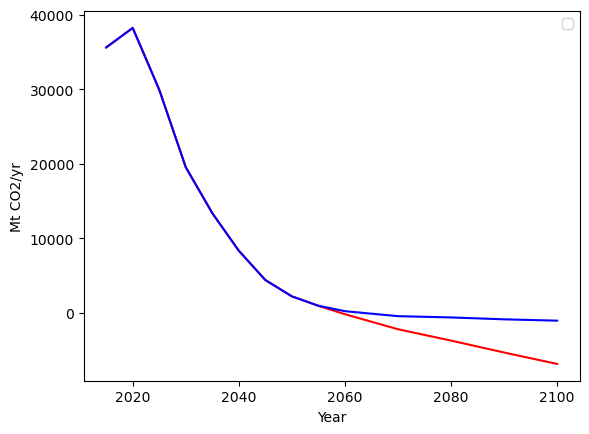

In [22]:
fig, ax = plt.subplots()

test.filter(
    variable='*Emissions|CO2|Energy and Industrial Processes'
).plot(ax=ax, color='red')

emissions_for_iteration.filter(
    variable='*Emissions|CO2|Energy and Industrial Processes'
).plot(ax=ax, color='blue')

ax.set_title('')

Step 6: Create the input for MAGICC and run this through for a first cut.

In [23]:
input_scm = scmdata.ScmRun(
    clean_wg3_scenarios(test)
)

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


In [24]:
temp_confirmation =  openscm_runner.run(
    {'MAGICC7':config_for_run},
    input_scm,
    output_variables=[
        'Surface Temperature'
    ]
)

Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/openscm_units/_unit_registry.py:471: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for label, val in metric_conversion.iteritems():


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-d67qslir
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-d67qslir
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-d67qslir/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-d67qslir
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


In [25]:
temp_proc = (
    temp_confirmation
    .filter(region='World')
    .relative_to_ref_period_mean(
        year=[1850, 1900]
    )
    .timeseries()
)

In [26]:
temp_calibrate_2100 = temp_proc['2100-01-01'].values[0].round(2)

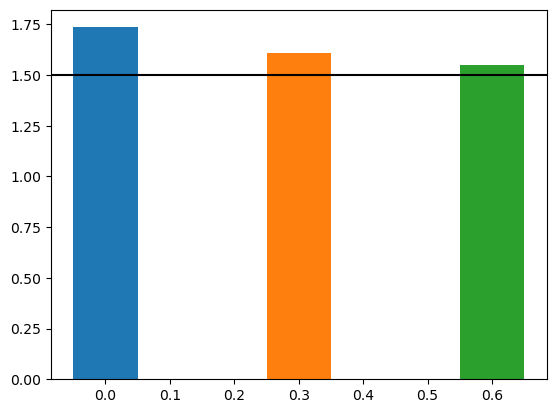

In [27]:
fig, ax = plt.subplots()

metrics_small = metrics.loc[
    (MODEL, SCENARIO, ENSEMBLE_MEMBER),
]

ax.bar(x=0, height=metrics_small['peak_warming'], width=0.1)
ax.bar(x=0.3, height=metrics_small['2100_warming'], width=0.1)
ax.bar(x=0.6, height=temp_calibrate_2100, width=0.1)
ax.axhline(1.5, color='black')

Step 7: Now that we know the direction (whether above or below), we now need a few calibration runs to get to the correct direction.

In [28]:
deviation = temp_calibrate_2100 - 1.5
print(deviation)

0.050000000000000044


In [29]:
def return_temperature_deviation(input_emissions):
    # Step 1: Run this through the simple climate model
    temperatures = openscm_runner.run(
        {'MAGICC7':config_for_run},
        input_emissions,
        output_variables=[
            'Surface Temperature'
        ]    
    )
    # Step 2: Rebase to 1850-1900 and return the 2100 value deviation
    temperatures_rebased = (
        temperatures
        .filter(region='World')
        .relative_to_ref_period_mean(year=[1850, 1900])
    )
    temp_2100 = (
        temperatures_rebased
        .timeseries()['2100-01-01']
        .values[0]
    )
    # Step 3: Return the deviation
    return temp_2100 - 1.5

In [30]:
novel_cdr_for_iteration.angle[0]
if deviation < 0:
    calibrate_type = 'reduce'
elif deviation > 0:
    calibrate_type = 'increase'
else:
    calibrate_type = 'none'

In [31]:
novel_cdr_for_iteration

<class 'pyam.core.IamDataFrame'>
Index:
 * model           : REMIND-MAgPIE 2.1-4.3 (1)
 * scenario        : DeepElec_SSP2_ HighRE_Budg900 (1)
Timeseries data coordinates:
   region          : World (1)
   variable        : Carbon Dioxide Removal|Novel (1)
   unit            : Mt CO2/yr (1)
   angle           : 89.57547881428569 (1)
   ensemble_member : 4 (1)
   year            : 2005, 2010, 2015, 2016, 2017, 2018, 2019, ... 2100 (88)
Meta indicators:
   exclude (bool) False (1)
   netzero|CO2 (int64) 2057 (1)

In [32]:
novel_cdr_original_filtered.meta = novel_cdr_for_iteration.meta

In [33]:
def initial_calibration(
        emissions,
        cdr_first_guess,
        angle_first_guess,
        current_deviation
):
    # Step 1: Create a dictionary to store the calibrations
    calibration = {}
    emissions_copy = copy.deepcopy(emissions)
    cdr = copy.deepcopy(cdr_first_guess)
    # Step 2: Determine walk direction
    if current_deviation > 0:
        new_deviation = current_deviation
        step_size=0.5
        while new_deviation > 0:
            new_angle = angle_first_guess + step_size
            print(new_deviation, new_angle)
            if new_angle > 91:
                break
            new_cdr, _ = rotate_and_calc_cumulative(
                cdr,
                new_angle
            )
            new_emissions = (
                scmdata.ScmRun(
                    clean_wg3_scenarios(
                        construct_new_emissions_dataframe(
                            emissions_copy,
                            process_novel_cdr(new_cdr, cdr.meta['netzero|CO2'].values[0])
                        )
                    
                    )
                )
            )
            new_deviation = return_temperature_deviation(new_emissions)
            calibration[new_angle] = new_deviation
            step_size += step_size
    elif current_deviation < 0:
        step_size=5
        new_deviation = current_deviation
        while new_deviation < 0:
            new_angle = angle_first_guess - step_size
            if new_angle < 0:
                break
            print(new_deviation, new_angle)
            new_cdr, _ = rotate_and_calc_cumulative(
                cdr,
                new_angle
            )
            new_emissions = (
                scmdata.ScmRun(
                    clean_wg3_scenarios(
                        construct_new_emissions_dataframe(
                            emissions_copy,
                            process_novel_cdr(new_cdr, cdr.meta['netzero|CO2'].values[0])
                        )
                    
                    )
                )
            )
            new_deviation = return_temperature_deviation(new_emissions)
            calibration[new_angle] = new_deviation
            step_size += step_size
    return pd.DataFrame(
        calibration.items(),
        columns=['angle', 'deviation']
    )

In [34]:
initial_calibration_set = initial_calibration(
    emissions_for_iteration,
    novel_cdr_original_filtered,
    novel_cdr_for_iteration.angle[0],
    current_deviation=deviation,
)

0.050000000000000044 90.07547881428569


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-u89qj1i6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-u89qj1i6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-u89qj1i6/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-u89qj1i6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


0.4250717645928386 90.57547881428569


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-bt7uspzh
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-bt7uspzh
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-bt7uspzh/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-bt7uspzh
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


0.15010343564920792 91.57547881428569


In [35]:
initial_calibration_set

,angle,deviation
0,90.075479,0.425072
1,90.575479,0.150103


In [36]:
def objective(angle, emissions, cdr_first_guess):
    # Step 1: Get the new CDR pathway
    new_cdr, _ = rotate_and_calc_cumulative(
        cdr_first_guess,
        angle
    )
    # Step 2: Get the new emissions pathway
    new_emissions = (
        scmdata.ScmRun(
            clean_wg3_scenarios(
                construct_new_emissions_dataframe(
                    emissions,
                    process_novel_cdr(new_cdr, cdr_first_guess.meta['netzero|CO2'].values[0])
                )        
            )
        )
    )
    new_deviation = abs(return_temperature_deviation(new_emissions))
    return new_deviation

In [37]:
novel_cdr_for_iteration.angle[0]

89.57547881428569

In [38]:
if calibrate_type == 'increase':
    try: max_angle = min(90, initial_calibration_set.iloc[-1]['angle'])
    except: max_angle=90
    bounds = (novel_cdr_for_iteration.angle[0], max_angle)
elif calibrate_type == 'reduce':
    try: min_angle = max(0, initial_calibration_set.iloc[-1]['angle'])
    except: min_angle=0
    bounds = (min_angle, novel_cdr_for_iteration.angle[0])
elif calibrate_type == 'none':
    bounds = (novel_cdr_for_iteration.angle[0], novel_cdr_for_iteration.angle[0]) # Catch the issue where deviation is 0

In [39]:
bounds

(89.57547881428569, 90)

try:
    max_angle = min(90, initial_calibration_set.iloc[-1]['angle'])
except: max_angle=90

In [40]:
result = minimize_scalar(
    objective,
    bounds=bounds,
    args=(emissions_for_iteration, novel_cdr_original_filtered),
    method='bounded'
)

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-k8_nc92q
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-k8_nc92q
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-k8_nc92q/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-k8_nc92q
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-surnqjo2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-surnqjo2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-surnqjo2/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-surnqjo2
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-3zpvxb69
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-3zpvxb69
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-3zpvxb69/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-3zpvxb69
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-sb75hf_6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-sb75hf_6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-sb75hf_6/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-sb75hf_6
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-z7943j_1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-z7943j_1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-z7943j_1/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-z7943j_1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-3b5gm6iu
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-3b5gm6iu
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-3b5gm6iu/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-3b5gm6iu
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-5fhzd07g
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-5fhzd07g
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-5fhzd07g/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-5fhzd07g
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-5mkk4bjk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-5mkk4bjk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-5mkk4bjk/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-5mkk4bjk
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-j3ojnpn0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-j3ojnpn0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-j3ojnpn0/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-j3ojnpn0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-on0g8ajy
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-on0g8ajy
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-on0g8ajy/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-on0g8ajy
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-_nr_mcp0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-_nr_mcp0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-_nr_mcp0/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-_nr_mcp0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-vi5fg4wp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-vi5fg4wp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-vi5fg4wp/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-vi5fg4wp
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-77ju5usj
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-77ju5usj
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-77ju5usj/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-77ju5usj
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-8k79tqk1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-8k79tqk1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-8k79tqk1/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-8k79tqk1
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-ue41psll
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-ue41psll
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-ue41psll/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-ue41psll
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-_r0l7ob0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-_r0l7ob0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-_r0l7ob0/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-_r0l7ob0
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-kfrx63jr
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-kfrx63jr
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-kfrx63jr/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-kfrx63jr
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


In [41]:
result

 message: Solution found.
 success: True
  status: 0
     fun: 1.042702947540164e-06
       x: 89.76267740841236
     nit: 17
    nfev: 17

In [42]:
if result.fun > 0.1:
   result = minimize_scalar(
        objective,
        bounds=(0,90),
        args=(emissions_for_iteration, novel_cdr_original_filtered),
        method='bounded'
    ) 

Last step: Make a function to construct and return the necessary CDR and temperature pathways.

In [43]:
def objective(angle, emissions, cdr_first_guess):
    # Step 1: Get the new CDR pathway
    new_cdr, _ = rotate_and_calc_cumulative(
        cdr_first_guess,
        angle
    )
    # Step 2: Get the new emissions pathway
    new_emissions = (
        scmdata.ScmRun(
            clean_wg3_scenarios(
                construct_new_emissions_dataframe(
                    emissions,
                    process_novel_cdr(new_cdr, cdr_first_guess.meta['netzero|CO2'].values[0])
                )        
            )
        )
    )
    new_deviation = abs(return_temperature_deviation(new_emissions))
    return new_deviation

In [44]:
def compile_necessary_output_files(result):
    # Step 1: Get the new CDR pathway
    new_cdr, cumulative_cdr = rotate_and_calc_cumulative(
        novel_cdr_original_filtered,
        result.x
    )
    new_cdr.set_meta(
        name='cumulative_cdr',
        meta=cumulative_cdr
    )
    # Step 2: Get the new emissions pathway
    new_emissions = (
        scmdata.ScmRun(
            clean_wg3_scenarios(
                construct_new_emissions_dataframe(
                    emissions_for_iteration,
                    process_novel_cdr(new_cdr, novel_cdr_original_filtered.meta['netzero|CO2'].values[0])
                )        
            )
        )
    )
    # Step 4: Calculate the warming
    new_warming = openscm_runner.run(
        {'MAGICC7':config_for_run},
        new_emissions,
        output_variables=[
            'Surface Temperature'
        ]    
    )
    # Step 4: Rebase and return
    new_warming_rebased = (
        new_warming
        .filter(region='World')
        .relative_to_ref_period_mean(year=[1850, 1900])
    )
    return new_cdr, new_warming_rebased

In [45]:
cdr_pathway, temperature_pathway = compile_necessary_output_files(result)

/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/climate_assessment/climate/wg3.py:42: FutureWarning: The default value of regex will change from True to False in a future version.
  df_clean["variable"] = df_clean["variable"].str.replace(old, new)


Climate models:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7.magicc7 - WARNING: Historical data has not been checked


Writing SCEN7 files:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Entered _parallel_magicc_compact_out
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Running in parallel with up to 4 workers


Front serial:   0%|          | 0.00/1.00 [00:00<?, ?it/s]

openscm_runner.adapters.magicc7._magicc_instances - INFO: Creating new magicc instance: (7, 'MainProcess') - /mnt/gaurav/pymagicc-ddrf6qoi
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Setting up MAGICC worker in /mnt/gaurav/pymagicc-ddrf6qoi
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Writing Pymagicc compatible MAGCFG_USER.CFG in /mnt/gaurav/pymagicc-ddrf6qoi/run
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATCONT_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pymagicc/core.py:387: UserWarning: Not reading file: DAT_HEATUPTK_EBALANCE_SUBANN.BINOUT. Monthly data are not read in automatically by `run`. Use `MAGICCData` instead.
  warnings.warn(


Front parallel: 0.00it [00:00, ?it/s]

Parallel runs: 0.00it [00:00, ?it/s]

openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Appending results into a single ScmRun
openscm_runner.adapters.magicc7._magicc_instances - INFO: removing /mnt/gaurav/pymagicc-ddrf6qoi
openscm_runner.adapters.magicc7._run_magicc_parallel - INFO: Shutting down parallel pool
openscm_runner.run - INFO: Only one model run, returning its results


/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/pyam/plotting.py:1073: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col, data in df.iteritems():
/home/gaurav/.conda/envs/cdr_climate_uncertainty/lib/python3.10/site-packages/scmdata/plotting.py:79: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  ax = sns.lineplot(data=plt_df, **kwargs)


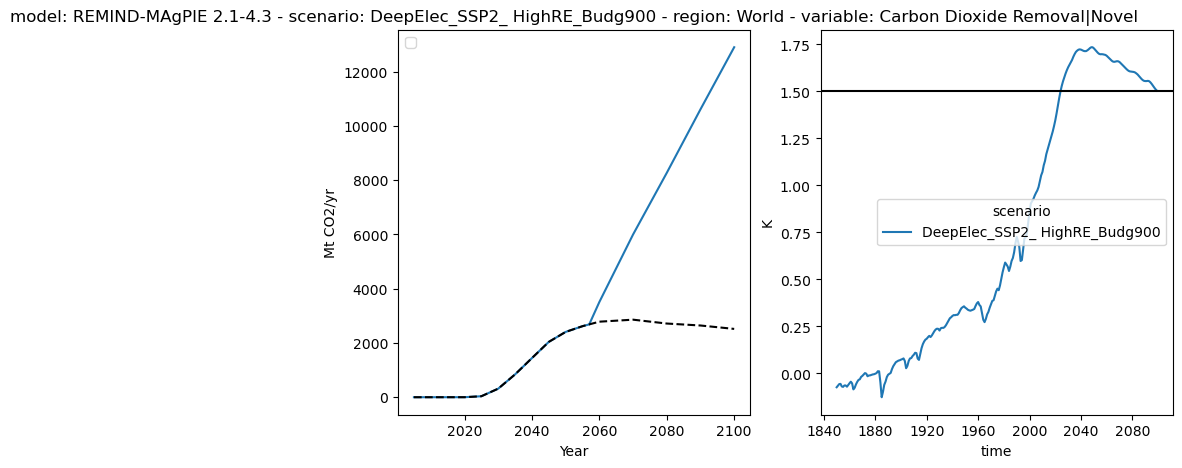

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# First, plot the CDR pathway
cdr_pathway.plot(ax=ax[0])
novel_cdr_original_filtered.plot(ax=ax[0], color='black', linestyle='--')

# Plot the temperature
temperature_pathway.filter(year=range(1850, 2100)).line_plot(ax=ax[1])
ax[1].axhline(1.5, color='black')

Save the files out for further assessment.

In [47]:
output_path=os.environ['OUTPUT_PATH']

In [48]:
cdr_pathway.to_csv(
    Path(
        f"{output_path}/results/CDR_{MODEL}_{SCENARIO}_{ENSEMBLE_MEMBER}.csv"
    )
)

In [49]:
temperature_pathway.to_csv(
    Path(
        f"{output_path}/results/TEMP_{MODEL}_{SCENARIO}_{ENSEMBLE_MEMBER}.csv"
    )
)